In [3]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchinfo import summary

from matplotlib import pyplot as plt
from timeit import default_timer as timer 
import random

from config import data_config, unet_config

from src.utils import *
from src.datafactory import SatelliteDataset, SatellitePatchesDataset, create_dataloaders
from src import engine
from models.unet import Unet
from src.transforms import train_transforms, val_transforms

from codecarbon import EmissionsTracker

In [4]:
from torch.utils.tensorboard import SummaryWriter

In [5]:
NUM_WORKERS = os.cpu_count()

# Setup data configs
data_config = data_config.data_config()

# Setup hyperparameters
unet_hyperparams = unet_config.unet_config()

seed_everything(seed = unet_hyperparams.global_seed)


# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(unet_hyperparams.LOGS_DIR)

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device = ", device)

Device =  cpu


### Load Patch Images 

In [6]:

patches_images = torch.load(data_config.PATCHES_DATA_PATH + 'patches_images.pt')
patches_masks = torch.load(data_config.PATCHES_DATA_PATH + 'patches_masks.pt')

print(patches_images.shape, patches_masks.shape)

(1305, 256, 256, 3) (1305, 256, 256)


### Visualize Patches Images

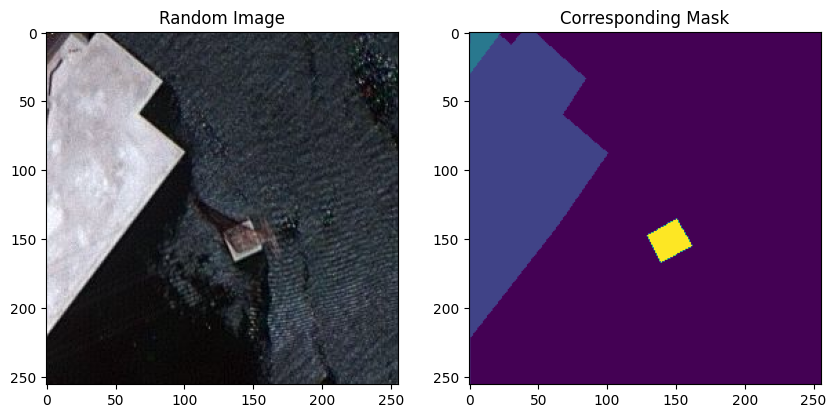

In [7]:
display_random_image_and_mask(patches_images, patches_masks,tensorboard_writer=writer)

### Load Train, Val and Test sets

In [8]:
Xtrain_patches = torch.load(data_config.TRAIN_DATA_PATH + 'Xtrain_patches.pt')
ytrain_patches = torch.load(data_config.TRAIN_DATA_PATH + 'ytrain_patches.pt')

Xval_patches = torch.load(data_config.VAL_DATA_PATH + 'Xval_patches.pt')
yval_patches = torch.load(data_config.VAL_DATA_PATH + 'yval_patches.pt')

Xtest_patches = torch.load(data_config.TEST_DATA_PATH + 'Xtest_patches.pt')
ytest_patches  = torch.load(data_config.TEST_DATA_PATH + 'ytest_patches.pt')

Xtrain_patches.shape, Xval_patches.shape, Xtest_patches.shape, ytrain_patches.shape, yval_patches.shape, ytest_patches.shape

((913, 256, 256, 3),
 (261, 256, 256, 3),
 (131, 256, 256, 3),
 (913, 256, 256),
 (261, 256, 256),
 (131, 256, 256))

### Setup data transformation

### Instantiate train and test dataset 

In [9]:
train_dataset = SatellitePatchesDataset(patches_images=Xtrain_patches,
                  patches_masks=ytrain_patches,
                  transform=train_transforms)

val_dataset = SatellitePatchesDataset(patches_images= Xval_patches,
                  patches_masks= yval_patches,
                  transform=val_transforms)

test_dataset = SatellitePatchesDataset(patches_images= Xtest_patches,
                  patches_masks= ytest_patches,
                  transform=val_transforms)

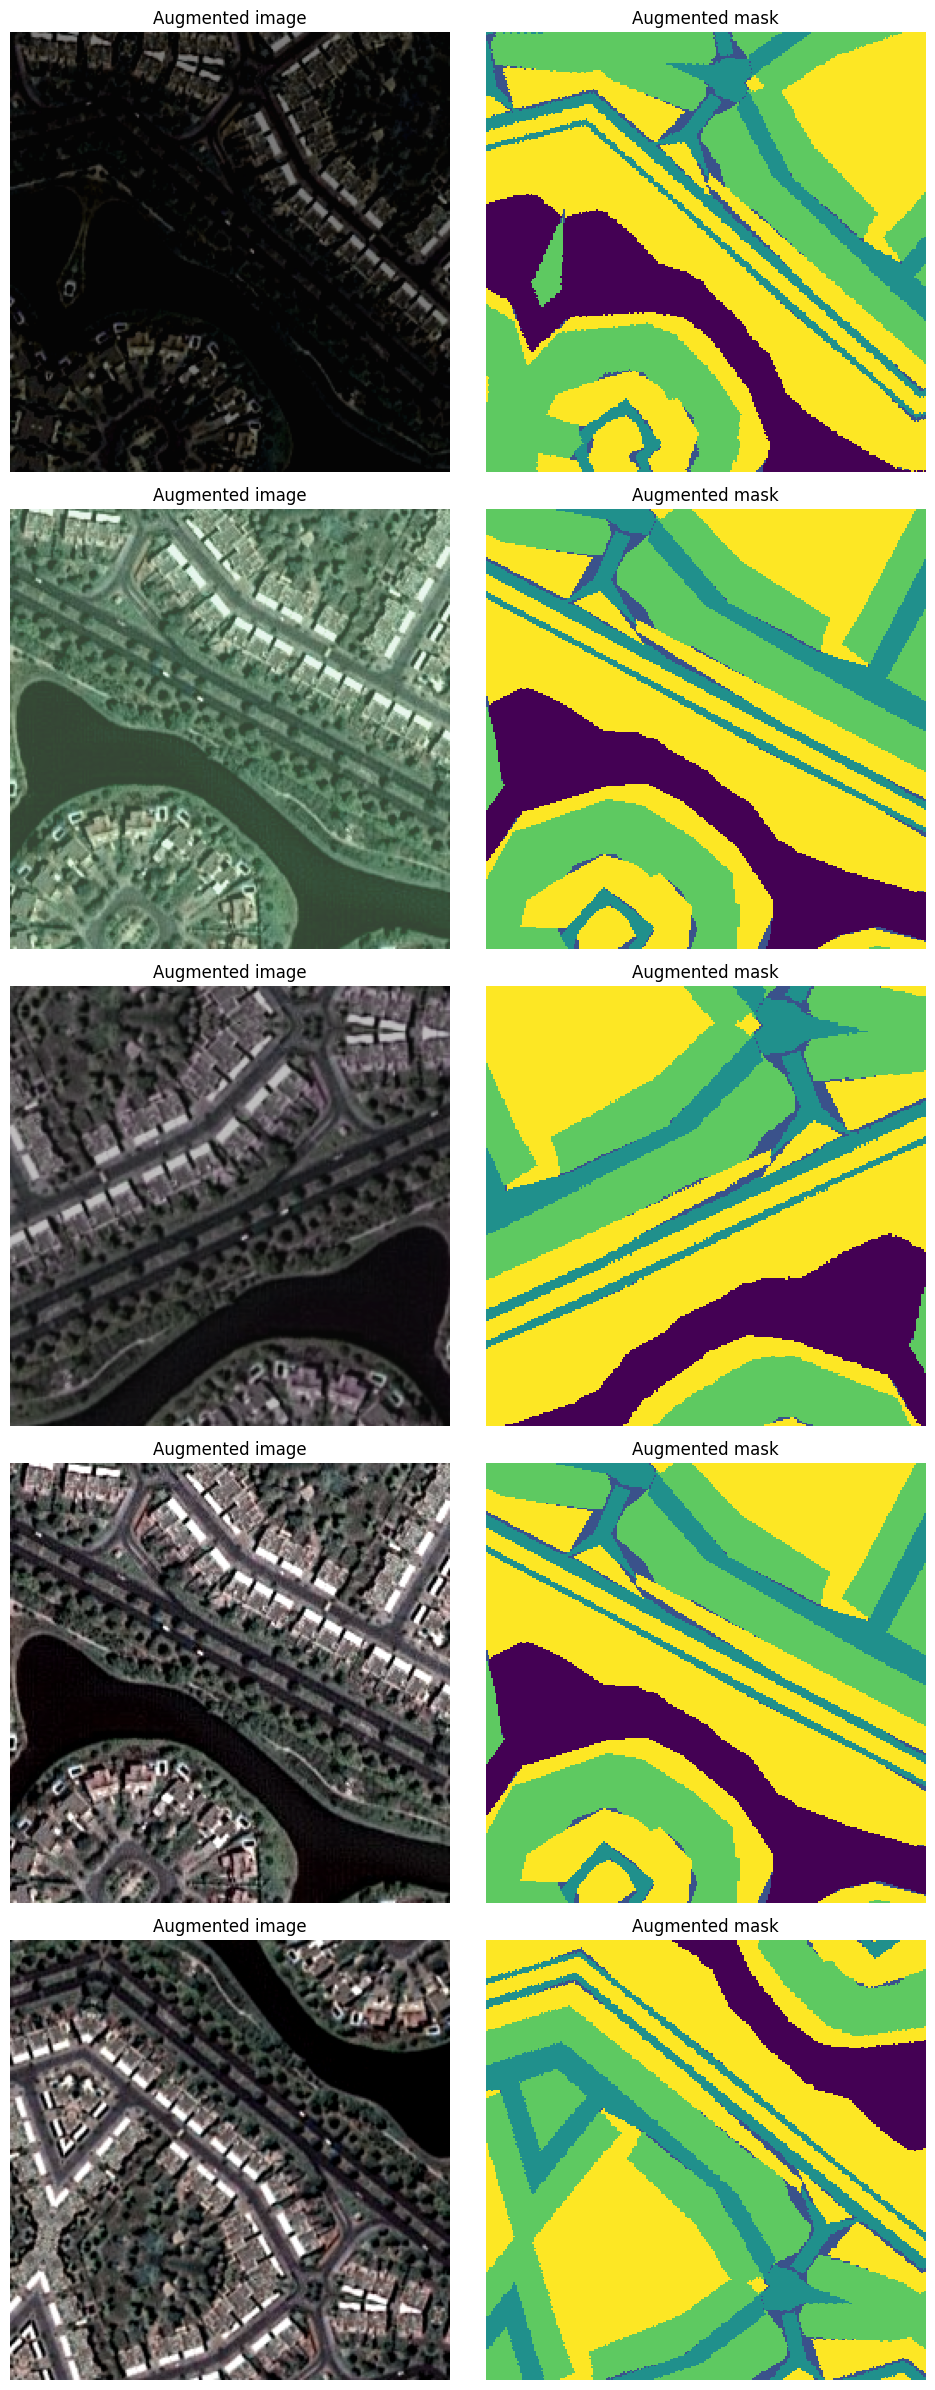

In [10]:
random.seed(42)
visualize_augmentations(train_dataset, idx=55)

### Create Train & Test dataloaders

In [12]:
train_dataloader = create_dataloaders(dataset=train_dataset, 
                                      batch_size= unet_hyperparams.BATCH_SIZE,
                                      num_workers=NUM_WORKERS,)

val_dataloader = create_dataloaders(dataset=val_dataset, 
                                     batch_size= unet_hyperparams.BATCH_SIZE,
                                     num_workers=NUM_WORKERS,)

test_dataloader = create_dataloaders(dataset=test_dataset, 
                                     batch_size= unet_hyperparams.BATCH_SIZE,
                                     num_workers=NUM_WORKERS,)

In [13]:
batchX0, batchy0 = next(iter(train_dataloader))
batchX0.shape, batchy0.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 256]))

### Intanciate Model and add graph to tensorboard

In [15]:


model = Unet(in_channels = unet_hyperparams.IN_CHANNELS, 
             n_classes = unet_hyperparams.NUM_CLASSES,
             upsample= unet_hyperparams.UPSAMPLE,
             upsample_mode = unet_hyperparams.UPSAMPLE_MODE,
             level_channels = unet_hyperparams.LEVEL_CHANNELS,
             bottleneck_channel = unet_hyperparams.BOTTLENECK_CHANNEL,)

input_example = torch.randn((2, 3, 256, 256))
writer.add_graph(model, input_example)

summary(model, input_size=input_example.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Unet                                     [2, 6, 256, 256]          --
├─encoder2d_block: 1-1                   [2, 64, 256, 256]         --
│    └─conv2d_block: 2-1                 [2, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                  [2, 32, 256, 256]         896
│    │    └─BatchNorm2d: 3-2             [2, 32, 256, 256]         64
│    │    └─ReLU: 3-3                    [2, 32, 256, 256]         --
│    │    └─Conv2d: 3-4                  [2, 64, 256, 256]         18,496
│    │    └─BatchNorm2d: 3-5             [2, 64, 256, 256]         128
│    │    └─ReLU: 3-6                    [2, 64, 256, 256]         --
│    └─MaxPool2d: 2-2                    [2, 64, 128, 128]         --
├─encoder2d_block: 1-2                   [2, 128, 128, 128]        --
│    └─conv2d_block: 2-3                 [2, 128, 128, 128]        --
│    │    └─Conv2d: 3-7                  [2, 64, 128, 128]         36,928
│    

### Start training with help from engine.py


In [18]:

# setup CO2 emissions tracker
tracker = EmissionsTracker()
tracker.start()

# Start the timer
start_time = timer()

results = engine.train(model=model,
             train_loader=train_dataloader,
             val_loader=test_dataloader,
             optimizer=unet_hyperparams.OPTIMIZER(model.parameters(), lr=unet_hyperparams.LEARNING_RATE),
             criterion= unet_hyperparams.LOSS_FN,
             metrics=unet_hyperparams.METRICS,
             num_classes=unet_hyperparams.NUM_CLASSES,
             num_epochs=unet_hyperparams.NUM_EPOCHS,
             tensorboard_writer=writer,
             device=device)

end_time = timer()

emissions: float = tracker.stop()

[codecarbon INFO @ 23:26:57] [setup] RAM Tracking...
[codecarbon INFO @ 23:26:57] [setup] GPU Tracking...
[codecarbon INFO @ 23:26:57] No GPU found.
[codecarbon INFO @ 23:26:57] [setup] CPU Tracking...
[codecarbon WARNING @ 23:26:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 23:26:58] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz
[codecarbon INFO @ 23:26:58] >>> Tracker's metadata:
[codecarbon INFO @ 23:26:58]   Platform system: Linux-6.5.0-17-generic-x86_64-with-glibc2.35
[codecarbon INFO @ 23:26:58]   Python version: 3.10.12
[codecarbon INFO @ 23:26:58]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 23:26:58]   Available RAM : 7.535 GB
[codecarbon INFO @ 23:26:58]   CPU count: 8
[codecarbon INFO @ 23:26:58]   CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz
[codecarbon INFO @ 23:26:58]   GPU count: None
[codecarbon INFO @ 23:26:58]   GPU model: None
  0%|          | 0/10 [00:00<?, ?it/s][codecarbon INFO @

### Log train_time and CO2 emissions to tensorboard

In [ ]:
train_time = print_train_time(start=start_time, end=end_time, device=device)
writer.add_scalar('Training time', train_time, 0)

print("CO2 Emissions : ", emissions)
writer.add_scalar('CO2 Emissions', emissions, 0)

In [ ]:
# Save the model with help from utils.py
save_model(model=model,
                 target_dir=unet_hyperparams.MODEL_DIR,
                 model_name=unet_hyperparams.MODEL_NAME)